**Installing conda and rdkit**

In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
import pandas as pd
df = pd.read_csv('acetylcholinesterase_03_bioactivity_data_curated.csv')


In [ ]:
df

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active
...,...,...,...,...
4690,CHEMBL4293155,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3Cl)CC...,2440.0,intermediate
4691,CHEMBL4282558,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc(Cl)c3)...,2540.0,intermediate
4692,CHEMBL4281727,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...,3810.0,intermediate
4693,CHEMBL4292349,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...,3460.0,intermediate


In [ ]:
df_no_smiles = df.drop(columns='canonical_smiles')

In [ ]:
smiles = []

for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [ ]:
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles

,molecule_chembl_id,standard_value,class,canonical_smiles
0,CHEMBL133897,750.0,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1
1,CHEMBL336398,100.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1
2,CHEMBL131588,50000.0,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1
3,CHEMBL130628,300.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F
4,CHEMBL130478,800.0,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C
...,...,...,...,...
4690,CHEMBL4293155,2440.0,intermediate,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3Cl)CC...
4691,CHEMBL4282558,2540.0,intermediate,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc(Cl)c3)...
4692,CHEMBL4281727,3810.0,intermediate,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...
4693,CHEMBL4292349,3460.0,intermediate,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...


## **Calculating Lipinski descriptors**

Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the druglikeness of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the Rule-of-Five or Lipinski's Rule.

The Lipinski's Rule stated the following:

Molecular weight (MW)< 500 Dalton

Octanol-water partition coefficient (LogP) < 5

Hydrogen bond donors(NumHDonors) < 5

Hydrogen bond acceptors (NumHAcceptors)< 10


In [ ]:
from rdkit import Chem
import numpy as np
from rdkit.Chem import Descriptors,Lipinski

In [ ]:
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [ ]:
df_lipinski= lipinski(df.canonical_smiles)

In [ ]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,312.325,2.80320,0.0,6.0
1,376.913,4.55460,0.0,5.0
2,426.851,5.35740,0.0,5.0
3,404.845,4.70690,0.0,5.0
4,346.334,3.09530,0.0,6.0
...,...,...,...,...
4690,511.150,7.07230,2.0,3.0
4691,511.150,7.07230,2.0,3.0
4692,555.601,7.18140,2.0,3.0
4693,521.702,6.32710,2.0,5.0


In [ ]:
df_combined=pd.concat([df_clean_smiles,df_lipinski],axis=1)

In [ ]:
df_combined

,molecule_chembl_id,standard_value,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL133897,750.0,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,312.325,2.80320,0.0,6.0
1,CHEMBL336398,100.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,376.913,4.55460,0.0,5.0
2,CHEMBL131588,50000.0,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,426.851,5.35740,0.0,5.0
3,CHEMBL130628,300.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,404.845,4.70690,0.0,5.0
4,CHEMBL130478,800.0,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,346.334,3.09530,0.0,6.0
...,...,...,...,...,...,...,...,...
4690,CHEMBL4293155,2440.0,intermediate,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3Cl)CC...,511.150,7.07230,2.0,3.0
4691,CHEMBL4282558,2540.0,intermediate,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc(Cl)c3)...,511.150,7.07230,2.0,3.0
4692,CHEMBL4281727,3810.0,intermediate,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...,555.601,7.18140,2.0,3.0
4693,CHEMBL4292349,3460.0,intermediate,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...,521.702,6.32710,2.0,5.0


##**Convert IC50 to pIC50**
To allow IC50 data to be more uniformly distributed, we will convert IC50 to the negative logarithmic scale which is essentially -log10(IC50).

This custom function pIC50() will accept a DataFrame as input and will:

Take the IC50 values from the standard_value column and converts it from nM to M by multiplying the value by 10$^{-9}$
Take the molar value and apply -log10
Delete the standard_value column and create a new pIC50 column

But before converting the IC value to pIC value we need to normalise the value of the given IC value i.e putting a upper cap on the highest possible value that the IC can have,as large numbers can result in -ve log value which is undesirable.

In [ ]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [ ]:
df_form=norm_value(df_combined)
df_form

,molecule_chembl_id,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL133897,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,312.325,2.80320,0.0,6.0,750.0
1,CHEMBL336398,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,376.913,4.55460,0.0,5.0,100.0
2,CHEMBL131588,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,426.851,5.35740,0.0,5.0,50000.0
3,CHEMBL130628,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,404.845,4.70690,0.0,5.0,300.0
4,CHEMBL130478,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,346.334,3.09530,0.0,6.0,800.0
...,...,...,...,...,...,...,...,...
4690,CHEMBL4293155,intermediate,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3Cl)CC...,511.150,7.07230,2.0,3.0,2440.0
4691,CHEMBL4282558,intermediate,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc(Cl)c3)...,511.150,7.07230,2.0,3.0,2540.0
4692,CHEMBL4281727,intermediate,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...,555.601,7.18140,2.0,3.0,3810.0
4693,CHEMBL4292349,intermediate,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...,521.702,6.32710,2.0,5.0,3460.0


This Function will convert IC to its corresponding pIC value

In [ ]:
import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [ ]:
df_final=pIC50(df_form)

In [ ]:
df_form

,molecule_chembl_id,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm,pIC50
0,CHEMBL133897,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,312.325,2.80320,0.0,6.0,750.0,6.124939
1,CHEMBL336398,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,376.913,4.55460,0.0,5.0,100.0,7.000000
2,CHEMBL131588,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,426.851,5.35740,0.0,5.0,50000.0,4.301030
3,CHEMBL130628,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,404.845,4.70690,0.0,5.0,300.0,6.522879
4,CHEMBL130478,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,346.334,3.09530,0.0,6.0,800.0,6.096910
...,...,...,...,...,...,...,...,...,...
4690,CHEMBL4293155,intermediate,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3Cl)CC...,511.150,7.07230,2.0,3.0,2440.0,5.612610
4691,CHEMBL4282558,intermediate,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc(Cl)c3)...,511.150,7.07230,2.0,3.0,2540.0,5.595166
4692,CHEMBL4281727,intermediate,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...,555.601,7.18140,2.0,3.0,3810.0,5.419075
4693,CHEMBL4292349,intermediate,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...,521.702,6.32710,2.0,5.0,3460.0,5.460924


**Removing the 'intermediate' bioactivity class**

Here, we will be removing the intermediate class from our data set.

In [ ]:
df_2class = df_final[df_final['class'] != 'intermediate']
df_2class

,molecule_chembl_id,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,312.325,2.8032,0.0,6.0,6.124939
1,CHEMBL336398,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,376.913,4.5546,0.0,5.0,7.000000
2,CHEMBL131588,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,426.851,5.3574,0.0,5.0,4.301030
3,CHEMBL130628,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,404.845,4.7069,0.0,5.0,6.522879
4,CHEMBL130478,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,346.334,3.0953,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
4675,CHEMBL4284261,inactive,CCN(C)Cc1cc(N)ccc1O,253.173,2.2697,2.0,3.0,3.015428
4676,CHEMBL4276921,inactive,CN(C)Cc1cc(N)ccc1O,239.146,1.8796,2.0,3.0,2.813467
4677,CHEMBL4292574,inactive,CNCc1cc(N)ccc1O,225.119,1.5374,3.0,3.0,3.476904
4685,CHEMBL4292766,active,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3F)CC2...,494.695,6.5580,2.0,3.0,6.124939


**Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks')

**Frequency plot of the 2 bioactivity classes**

Text(0, 0.5, 'Frequency')

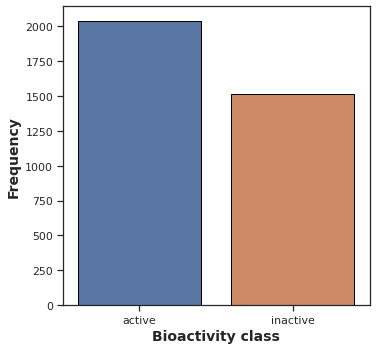

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')



**Scatter plot of MW versus LogP**

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.



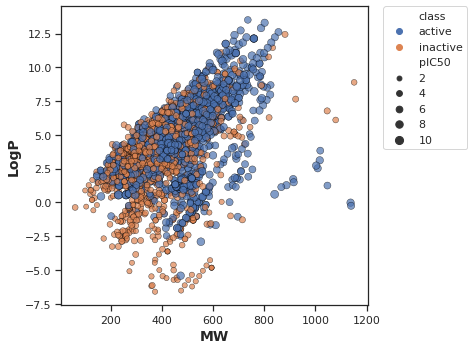

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)


**Box Plot**

pIC50 value

Text(0, 0.5, 'pIC50 value')

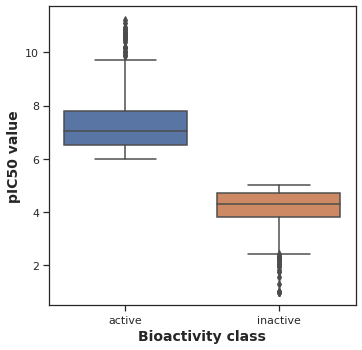

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')



**Statistical analysis  Mann-Whitney U Test**

In [ ]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_2class[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_2class[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [ ]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.0,0.0,0.05,Different distribution (reject H0)


**MW**

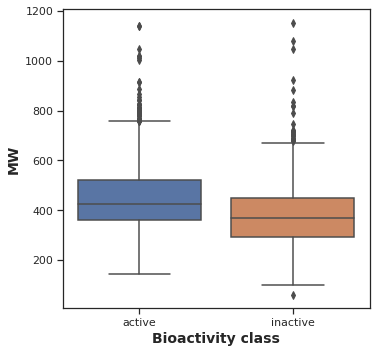

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [ ]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,1082631.5,4.670527e-52,0.05,Different distribution (reject H0)


**LogP**

Text(0, 0.5, 'LogP')

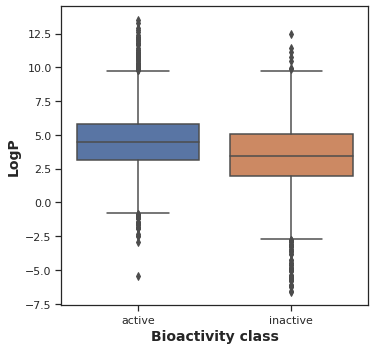

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')



In [ ]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,1139436.0,2.137479e-40,0.05,Different distribution (reject H0)


**NumHDonors**

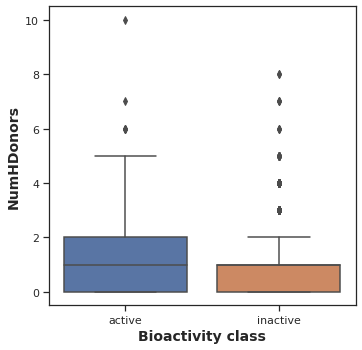

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

In [ ]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,1351722.5,3.165635e-11,0.05,Different distribution (reject H0)


**NumHAcceptors**

Text(0, 0.5, 'NumHAcceptors')

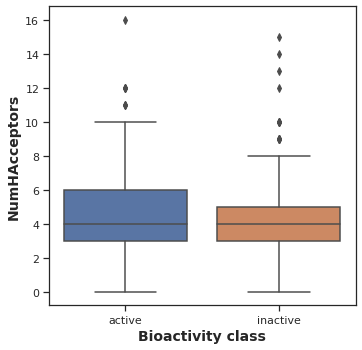

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')



In [ ]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,1396791.0,7.772505e-07,0.05,Different distribution (reject H0)


##Interpretation of Statistical Results

**Box Plots**

**pIC50 values**

Taking a look at pIC50 values, the actives and inactives displayed statistically significant difference, which is to be expected since threshold values (IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives, corresponding to pIC50 > 6 = Actives and pIC50 < 5 = Inactives) were used to define actives and inactives.

**Lipinski's descriptors**

Of the 4 Lipinski's descriptors (MW, LogP, NumHDonors and NumHAcceptors), only LogP exhibited no difference between the actives and inactives while the other 3 descriptors (MW, NumHDonors and NumHAcceptors) shows statistically significant difference between actives and inactives.